In [72]:
%matplotlib inline
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [73]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

# 回帰の基礎

## 確定的トレンド

確定的トレンドを単純パーセプトロンで分析します。


In [74]:
'''
kerasによる線形回帰
'''
# Training Data
x=np.arange(1,16)
print('オリジナルデータ')
print(x)
xpoints=x

オリジナルデータ
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [75]:
'''
データ作成
'''
# Training Data
train_X=xpoints[:-1]
train_y=xpoints[1:]

In [76]:
'''
モデル設定

'''
model = Sequential()
model.add(Dense(input_dim=1,kernel_initializer='uniform',activation='linear',units=1))

model.compile(loss='mse', optimizer='rmsprop')

In [77]:
'''
データの学習
'''
model.fit(
    train_X,
    train_y,
    batch_size=1,
    epochs=100,
    verbose=0)

重み [[0.98568946]] バイアス [1.1373376]


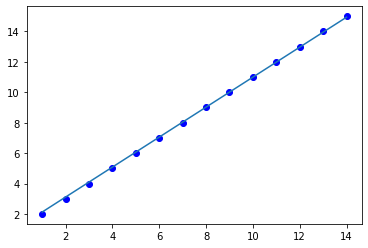

In [78]:
'''
結果出力
'''
w=model.get_weights()[0]
b=model.get_weights()[1]
Y=w[0]*train_X+b
print('重み',model.layers[0].get_weights()[0],'バイアス',model.layers[0].get_weights()[1])
plt.plot(train_X,train_y,'bo')
plt.plot(train_X,Y)

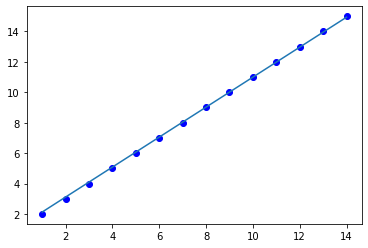

In [79]:
#predictメソッドの利用
pred=model.predict(train_X)
plt.plot(train_X,train_y,'bo')
plt.plot(train_X,pred)

### 評価の仕方

平均２乗誤差の利用

- 基準：明日の価格の最良の予測は今日の価格

- 訓練データ誤差と訓練データ予測誤差の比較
- テストデータ誤差とテストデータ予測誤差の比較
- 訓練データ予測誤差とテストデータ予測誤差の比較 -> 汎化性能


In [80]:
from sklearn.metrics import mean_squared_error

def evaluation(X_train,y_train,X_test,y_test,model):
    y_train0=y_train[:-1]
    y_train00=y_train[1:]
    y_test0=y_test[:-1]
    y_test00=y_test[1:]
    y_hat_train = model.predict(X_train, batch_size=1)
    y_hat_test = model.predict(X_test, batch_size=1)
    print('訓練データ誤差',mean_squared_error(y_train0, y_train00, multioutput='raw_values'))
    print('訓練データ予測誤差',mean_squared_error(y_hat_train, y_train, multioutput='raw_values'))
    print('テストデータ誤差',mean_squared_error(y_test0, y_test00, multioutput='raw_values'))
    print('テストデータ予測誤差',mean_squared_error(y_hat_test, y_test, multioutput='raw_values'))

evaluation(train_X,train_y,train_X,train_y,model=model)

訓練データ誤差 [1.]
訓練データ予測誤差 [0.00422838]
テストデータ誤差 [1.]
テストデータ予測誤差 [0.00422838]


### データの構造を変えてみよう

5つのデータを用いて予測をします。

入力データの構造の変化に注目してください。

In [81]:
X=[]
for i in range(len(xpoints)-5):
    X.append(xpoints[i:i+5])
train_X=np.asarray(X)
train_y = xpoints[5:]
print()
print('train_X')
print(train_X)
print('train_y')
print(train_y)


train_X
[[ 1  2  3  4  5]
 [ 2  3  4  5  6]
 [ 3  4  5  6  7]
 [ 4  5  6  7  8]
 [ 5  6  7  8  9]
 [ 6  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 12]
 [ 9 10 11 12 13]
 [10 11 12 13 14]]
train_y
[ 6  7  8  9 10 11 12 13 14 15]


- 入力の次元を変更しています。

In [82]:
model = Sequential([
    Dense(input_dim=5, units=1,kernel_initializer='uniform',activation='linear')
])

model.compile(loss='mse', optimizer='rmsprop')

model.fit(
    train_X,
    train_y,
    batch_size=1,
    epochs=1000,
    verbose=0)
reg=model.predict(train_X,batch_size=1)
print('重み')
print(model.layers[0].get_weights()[0])
print('バイアス')
print(model.layers[0].get_weights()[1])

重み
[[-0.17858869]
 [ 0.05421611]
 [ 0.21515141]
 [ 0.44775286]
 [ 0.46296215]]
バイアス
[1.3216727]


訓練データ誤差 [1.]
訓練データ予測誤差 [0.00010894]
テストデータ誤差 [1.]
テストデータ予測誤差 [0.00010894]


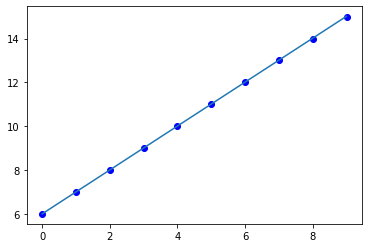

In [83]:
pred=model.predict(train_X)
plt.plot(train_y,'bo')
plt.plot(pred)
evaluation(train_X,train_y,train_X,train_y,model=model)

## 正弦波

確定的トレンドを正弦波に変えてみましょう。

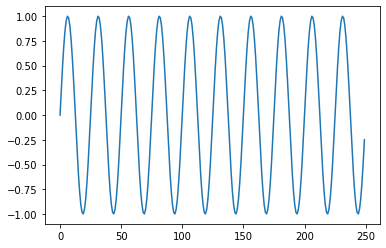

In [203]:
def sin_wave(p0=1,n=250,k=10,A=1):#k:
    x = np.arange(0, n )
    return (A*np.sin(2.0 * np.pi * x / n*k))*p0

tsd=pd.Series(sin_wave())
plt.plot(tsd)

In [204]:
# 入力特徴量の作成
tsd_data=tsd.iloc[:-1]
# 出力特徴量の作成　
tsd_target=tsd.iloc[1:]
print(tsd_data[:5])
print(tsd_target[:5])
# データがずれているのを確認

0    0.000000
1    0.248690
2    0.481754
3    0.684547
4    0.844328
dtype: float64
1    0.248690
2    0.481754
3    0.684547
4    0.844328
5    0.951057
dtype: float64


In [205]:
# 訓練データとテストデータの作成

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tsd_data.values, tsd_target.values,shuffle=False)
X_train

array([ 0.00000000e+00,  2.48689887e-01,  4.81753674e-01,  6.84547106e-01,
        8.44327926e-01,  9.51056516e-01,  9.98026728e-01,  9.82287251e-01,
        9.04827052e-01,  7.70513243e-01,  5.87785252e-01,  3.68124553e-01,
        1.25333234e-01, -1.25333234e-01, -3.68124553e-01, -5.87785252e-01,
       -7.70513243e-01, -9.04827052e-01, -9.82287251e-01, -9.98026728e-01,
       -9.51056516e-01, -8.44327926e-01, -6.84547106e-01, -4.81753674e-01,
       -2.48689887e-01, -2.44929360e-16,  2.48689887e-01,  4.81753674e-01,
        6.84547106e-01,  8.44327926e-01,  9.51056516e-01,  9.98026728e-01,
        9.82287251e-01,  9.04827052e-01,  7.70513243e-01,  5.87785252e-01,
        3.68124553e-01,  1.25333234e-01, -1.25333234e-01, -3.68124553e-01,
       -5.87785252e-01, -7.70513243e-01, -9.04827052e-01, -9.82287251e-01,
       -9.98026728e-01, -9.51056516e-01, -8.44327926e-01, -6.84547106e-01,
       -4.81753674e-01, -2.48689887e-01, -4.89858720e-16,  2.48689887e-01,
        4.81753674e-01,  

((186, 1), (186, 1), (63, 1), (63, 1))

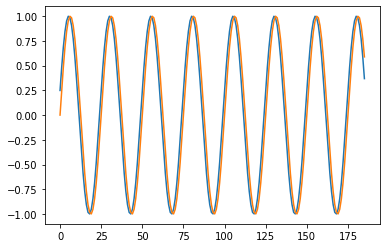

In [206]:
X_train=X_train[:,np.newaxis]
y_train=y_train[:,np.newaxis]
X_test=X_test[:,np.newaxis]
y_test=y_test[:,np.newaxis]
plt.plot(y_train)
plt.plot(X_train)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

In [207]:
# データの構造の確認
print("訓練データ　X")
print(X_train[:5])
print("訓練データ　y")
print(y_train[:5])

訓練データ　X
[[0.        ]
 [0.24868989]
 [0.48175367]
 [0.68454711]
 [0.84432793]]
訓練データ　y
[[0.24868989]
 [0.48175367]
 [0.68454711]
 [0.84432793]
 [0.95105652]]


In [208]:
np.random.seed(0)  # 乱数シード

'''
モデル設定
'''
model = Sequential([
    Dense(input_dim=1, units=2,activation='relu'),  
    #Dense(units=2,activation='relu'),  
    Dense(units=1,activation='linear')  # 出力層の活性化関数は恒等関数(linear)
])

model.compile(loss='mse', optimizer='rmsprop')
epochs=100

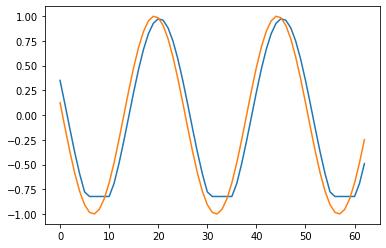

In [209]:
'''
モデル学習
'''
results=model.fit(X_train, y_train, epochs=epochs, batch_size=10,verbose=0, validation_data=(X_test, y_test))  # Keras 1

'''
学習結果の確認
    予測にはpredictを用いていることに注意。
'''
pred = model.predict(X_test, batch_size=1)
plt.plot(pred)
plt.plot(y_test)
#plt.plot(X_test)

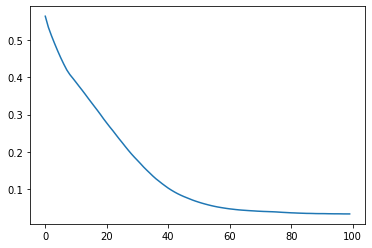

In [210]:
loss=results.history['loss'] #訓練データ誤差
val_loss=results.history['val_loss'] #テストデータに対する誤差
plt.plot(range(epochs),loss)

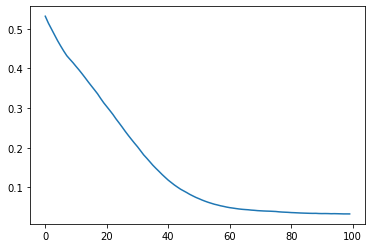

In [211]:
plt.plot(range(epochs),val_loss)
#classes

## データの構造を変えてみよう


((181, 5), (181,), (58, 5))

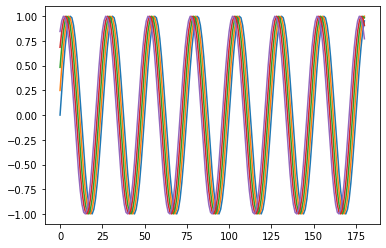

In [212]:
tsd_data=tsd.iloc[:-1]
tsd_target=tsd.iloc[1:]
X_train, X_test, y_train, y_test = train_test_split(tsd_data.values, tsd_target.values,shuffle=False)

# データ構造の変更
length=5
## 訓練データ
xx=[]
for x in range(length,len(X_train)):
    y=X_train[x-length:x]
    xx.append(y[:])
X_train=np.array(xx)
y_train=y_train[length:]
plt.plot(X_train)
## テストデータ
xx=[]
for x in range(length,len(X_test)):
    y=X_test[x-length:x]
    xx.append(y[:])
X_test=np.array(xx)
y_test=y_test[length:]
X_train.shape,y_train.shape,X_test.shape

In [213]:
np.random.seed(0)  # 乱数シード

'''
モデル設定
    入力データの次元を変更
    ユニットの数を変更
'''
model = Sequential([
    Dense(input_dim=length, units=2,activation='relu'), 
    #Dense(units=20,activation='relu'),  
    Dense(units=1,activation='linear')
])

model.compile(loss='mse', optimizer='rmsprop')

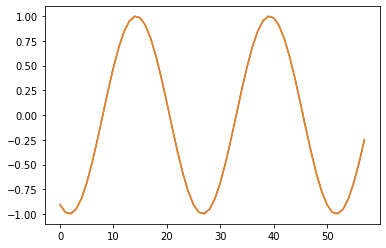

In [214]:
'''
モデル学習
'''
epochs=100
results=model.fit(X_train, y_train, epochs=epochs, batch_size=10,verbose=0, validation_data=(X_test, y_test))  # Keras 1

'''
学習結果の確認
'''
classes = model.predict(X_test, batch_size=1)
plt.plot(classes)
plt.plot(y_test)
#plt.plot(X_test)

In [215]:
y_train0=y_train[:-1]
y_train00=y_train[1:]
y_test0=y_test[:-1]
y_test00=y_test[1:]
X_hat_train = model.predict(X_train, batch_size=1)
print(mean_squared_error(y_train0, y_train00, multioutput='raw_values'))
print(mean_squared_error(X_hat_train, y_train, multioutput='raw_values'))
print(mean_squared_error(y_test0, y_test00, multioutput='raw_values'))
print(mean_squared_error(classes, y_test, multioutput='raw_values'))


[0.03113264]
[1.13682251e-06]
[0.03002914]
[1.47064798e-06]


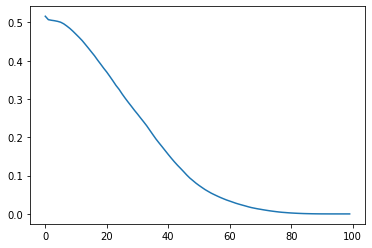

In [216]:
loss=results.history['loss']
val_loss=results.history['val_loss']
plt.plot(range(epochs),loss)

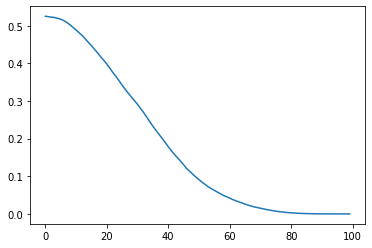

In [217]:
plt.plot(range(epochs),val_loss)
#classes